In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
flowlines = gpd.read_file('../data/flowlines_all.geojson')

cat = ['StreamOrde', 'StartFlag', 'TerminalFl', 'huc4']
num = ['AreaSqKM', 'LENGTHKM', 'ArbolateSu', 'SLOPE', 'MAXELEVSMO', 
       'MINELEVSMO', 'QA_MA', 'VA_MA', 'QA_01', 'VA_01']

flowlines.set_index('COMID', inplace=True)
flowlines = flowlines[cat + num]
flowlines

,StreamOrde,StartFlag,TerminalFl,huc4,AreaSqKM,LENGTHKM,ArbolateSu,SLOPE,MAXELEVSMO,MINELEVSMO,QA_MA,VA_MA,QA_01,VA_01
COMID,,,,,,,,,,,,,,
19772077,2,0,0,1806,0.1269,0.475,565.812,0.002926,9369.0,9230.0,0.096,0.63744,0.216,0.81453
19772079,4,0,0,1806,0.2376,1.036,557.847,0.001364,9351.0,9230.0,0.004,0.45006,0.009,0.52630
19772139,1,1,0,1806,8.4627,7.276,7.276,0.008793,16520.0,10255.0,0.153,0.74385,0.359,0.99330
19772159,2,0,0,1806,0.6291,1.606,11.969,0.002696,10255.0,9822.0,0.234,0.70639,0.541,0.92948
19772169,3,0,0,1806,1.6839,1.354,38.094,0.001411,9822.0,9631.0,0.725,0.77303,1.728,1.04530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8236560,1,0,0,1801,0.2583,0.575,1.380,0.300452,169131.0,151855.0,1.199,0.94602,1.805,1.10072
8235184,1,0,0,1801,0.1782,0.616,0.805,0.330763,189506.0,169131.0,0.862,0.90435,1.176,1.01122
8235174,1,0,0,1801,0.9630,1.233,2.613,0.245109,151855.0,121633.0,2.412,1.04157,4.188,1.29116


## Data Cleaning

In [3]:
flowlines = flowlines.replace(to_replace=[-9999.00, -9998.00], value=np.nan)

for col in ['QA_MA', 'VA_MA', 'QA_01', 'VA_01']:
    flowlines[col] = flowlines[col].replace(to_replace=0.00, value=np.nan)

for col in ['AreaSqKM', 'LENGTHKM', 'ArbolateSu','MAXELEVSMO', 'MINELEVSMO']:
    flowlines[col] = flowlines[col].replace(to_replace=0.00, value=np.nan)

# if slope is greater than 1, set to NaN
flowlines['SLOPE'].where(flowlines['SLOPE'] < 1.00, np.nan, inplace=True)

# Stream order of 0 is 'headwater' ? but fails this test, so not sure
#test = flowlines[flowlines['StreamOrde'] == 0]
# test['StartFlag'].value_counts()
# perhaps not connected to the network? 

# convert units
flowlines['MAXELEVSMO'] = flowlines['MAXELEVSMO'] / 100 # cm to m
flowlines['MINELEVSMO'] = flowlines['MINELEVSMO'] / 100 # cm to m

# log transform to AreaSqKM, ArbolateSu, QA_MA
flowlines['AreaSqKM'] = np.log(flowlines['AreaSqKM'])
flowlines['ArbolateSu'] = np.log(flowlines['ArbolateSu'])
flowlines['QA_MA'] = np.log(flowlines['QA_MA'])


# add simple_elevation column
flowlines['simple_elevation'] = (flowlines['MAXELEVSMO'] + flowlines['MINELEVSMO']) / 2

# drop not needed columns
flowlines = flowlines[["StreamOrde", "LENGTHKM", "AreaSqKM", "ArbolateSu", "SLOPE",  "simple_elevation", "QA_MA", "VA_MA", "huc4"]]

# rename columns
columns = {
    "StreamOrde": "stream_order",
    "LENGTHKM": "length_km",
    "AreaSqKM": "log_area_sq_km",
    "ArbolateSu": "log_upstream_length_km",
    "SLOPE": "slope",
    "simple_elevation": "elevation_m",
    "QA_MA": "log_mean_q_cfs",
    "VA_MA": "mean_v_fs",
    "huc4": "subregion"
}

num = ['length_km', 'log_area_sq_km', 'log_upstream_length_km', 'slope', 'elevation_m',  'log_mean_q_cfs', 'mean_v_fs']
cat = ['stream_order', 'subregion']
flowlines = flowlines.rename(columns=columns)
flowlines = flowlines.drop_duplicates()
flowlines


,stream_order,length_km,log_area_sq_km,log_upstream_length_km,slope,elevation_m,log_mean_q_cfs,mean_v_fs,subregion
COMID,,,,,,,,,
19772077,2,0.475,-2.064356,6.338262,0.002926,92.995,-2.343407,0.63744,1806
19772079,4,1.036,-1.437167,6.324085,0.001364,92.905,-5.521461,0.45006,1806
19772139,1,7.276,2.135668,1.984581,0.008793,133.875,-1.877317,0.74385,1806
19772159,2,1.606,-0.463465,2.482320,0.002696,100.385,-1.452434,0.70639,1806
19772169,3,1.354,0.521113,3.640057,0.001411,97.265,-0.321584,0.77303,1806
...,...,...,...,...,...,...,...,...,...
8236560,1,0.575,-1.353634,0.322083,0.300452,1604.930,0.181488,0.94602,1801
8235184,1,0.616,-1.724849,-0.216913,0.330763,1793.185,-0.148500,0.90435,1801
8235174,1,1.233,-0.037702,0.960499,0.245109,1367.440,0.880456,1.04157,1801


## Data Exploration

### % Missing Values from Each Column

In [4]:
(flowlines.isna().sum() / len(flowlines) * 100).round(2)

stream_order              0.00
length_km                 0.00
log_area_sq_km            1.41
log_upstream_length_km    1.21
slope                     1.74
elevation_m               1.79
log_mean_q_cfs            1.66
mean_v_fs                 7.21
subregion                 0.00
dtype: float64

## SubRegions Map

In [5]:
subregions = gpd.read_file('../data/subregions.geojson')
subregions

,OBJECTID,tnmid,metasourceid,sourcedatadesc,sourceoriginator,sourcefeatureid,loaddate,areaacres,areasqkm,states,huc4,name,shape_Length,shape_Area,referencegnis_ids,geometry
0,4,{0E918E79-0C68-4381-920B-3A08077F4ED3},{31AC21ED-1551-431B-963A-63D44B9887E8},None,U.S. Geological Survey,None,1641154835000,8472484.56,34286.96,CA,1806,Central California Coastal,1.969125e+06,5.197255e+10,None,"MULTIPOLYGON (((-122.11789 37.25463, -122.1183..."
1,5,{7E32DC94-E57D-4114-A4FA-8F91DCC89CC6},{93C374CC-EFFC-4F80-B73B-B02CB768ABCE},None,U.S. Geological Survey,None,1641219580000,8861368.04,35860.72,"CA,MX",1807,Southern California Coastal,2.174500e+06,5.186619e+10,None,"MULTIPOLYGON (((-119.10907 34.82365, -119.1093..."
2,6,{0D615870-DB12-485F-B551-125131FD9A46},None,None,None,None,1606900931000,18105223.06,73269.30,"CA,NV",1809,Northern Mojave-Mono Lake,2.930744e+06,1.121971e+11,None,"POLYGON ((-118.75945 38.32087, -118.75959 38.3..."
3,7,{8B9A6D8B-2257-402E-99C7-B88C5C95D776},{1FF46025-874C-4D4B-BD40-702A6B62DC21},None,U.S. Geological Survey,None,1647429883000,3437208.65,13909.90,CA,1805,San Francisco Bay,1.191326e+06,2.230339e+10,None,"MULTIPOLYGON (((-123.01419 37.94334, -123.0136..."
4,8,{64CCE751-2B6B-4196-A5B0-BEA80211D1AC},{93C374CC-EFFC-4F80-B73B-B02CB768ABCE},None,U.S. Geological Survey,None,1641219579000,10934157.74,44249.01,"CA,MX",1810,Southern Mojave-Salton Sea,1.938340e+06,6.418421e+10,None,"POLYGON ((-115.33798 35.26292, -115.33821 35.2..."
5,9,{DF00BF56-50CB-40DB-BBC6-DA6E52245DC1},{B9A0B744-98EC-42A3-8BF3-4F211A797F1E},None,U.S. Geological Survey,None,1641290908000,17794824.30,72013.16,"CA,OR",1802,Sacramento,2.993672e+06,1.230115e+11,None,"POLYGON ((-120.45820 42.43186, -120.45878 42.4..."
6,10,{63D04835-914F-4DE2-A52A-DC9414F3091D},{B9A0B744-98EC-42A3-8BF3-4F211A797F1E},None,U.S. Geological Survey,None,1641290908000,2913621.10,11791.02,"CA,NV",1808,North Lahontan,1.441143e+06,2.051798e+10,None,"POLYGON ((-120.18352 41.97436, -120.18398 41.9..."
7,87,{419D90DC-A7AA-4C8F-8269-2C3F59883D1F},{A0039473-A809-4129-8E12-32F32F5B835C},None,U.S. Geological Survey,None,1641219159000,10127904.92,40986.21,CA,1804,San Joaquin,1.643854e+06,6.553432e+10,None,"POLYGON ((-120.54011 38.75127, -120.54153 38.7..."
8,88,{91CB7D75-4CD6-4EC4-ACB5-8524A6DFB363},{31AC21ED-1551-431B-963A-63D44B9887E8},None,U.S. Geological Survey,None,1641154835000,10501344.46,42497.47,CA,1803,Tulare-Buena Vista Lakes,1.427577e+06,6.515506e+10,None,"POLYGON ((-118.90462 37.20802, -118.90541 37.2..."
9,192,{4A7807FE-7B9A-492A-AA96-460EE7B539F0},{1FF46025-874C-4D4B-BD40-702A6B62DC21},None,U.S. Geological Survey,None,1647429883000,16744234.15,67761.57,"CA,OR",1801,Klamath-Northern California Coastal,3.121428e+06,1.194310e+11,None,"POLYGON ((-121.63691 43.34029, -121.63660 43.3..."


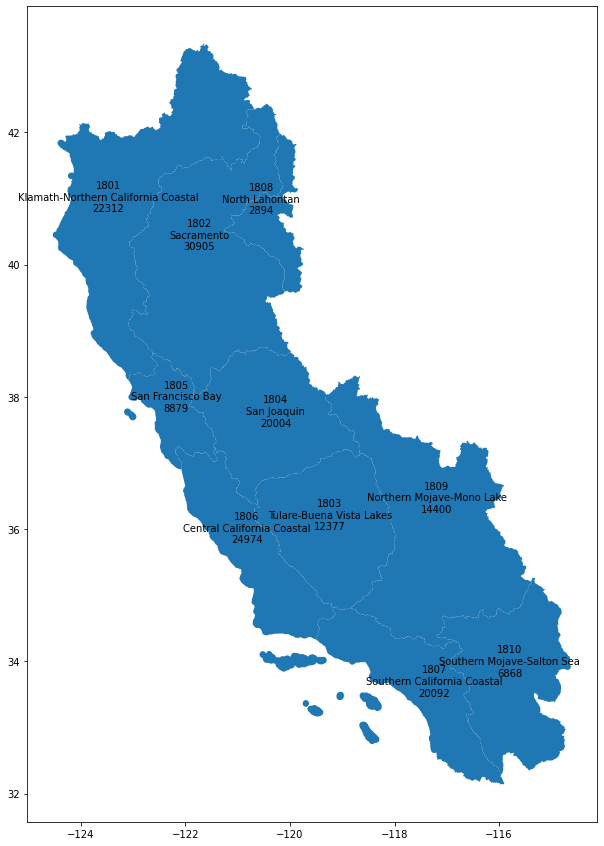

In [7]:
subregions.plot(figsize=(15,15))
subregions['coords'] = subregions['geometry'].apply(lambda x: x.representative_point().coords[:])
subregions['coords'] = [coords[0] for coords in subregions['coords']]
subregions['label'] = subregions['huc4'] + '\n' + subregions['name']
for idx, row in subregions.iterrows():
    count = (flowlines['subregion'] == row['huc4']).sum()
    label = row['label'] + '\n' + str(count)
    plt.annotate(text=label, xy=row['coords'], horizontalalignment='center')

### Categorical Variables

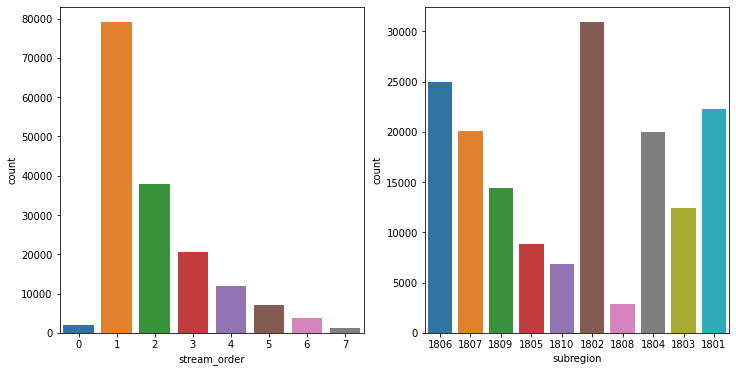

In [8]:
# Number of streams per subregion and stream_order
fig, axs = plt.subplots(1,2, figsize=(12, 6))
for axis,col in zip(axs, cat):
    sns.countplot(x=col, data=flowlines, ax=axis)

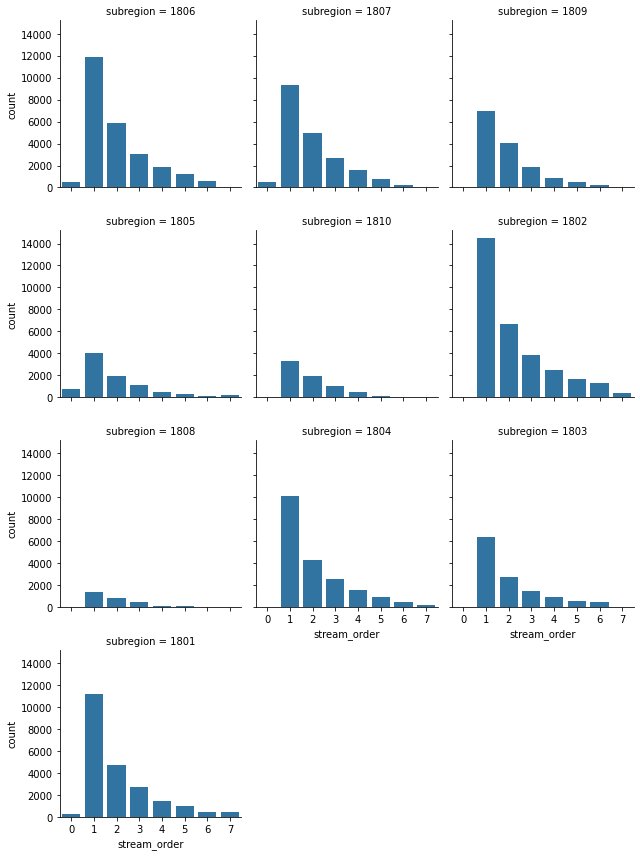

In [9]:
# stream order by region
cond_plot = sns.FacetGrid(flowlines, col='subregion', col_wrap=3)
cond_plot.map(sns.countplot, 'stream_order', order=range(0, 8))

## Numerical Variables

In [10]:
flowlines[num].describe().round(2)

,length_km,log_area_sq_km,log_upstream_length_km,slope,elevation_m,log_mean_q_cfs,mean_v_fs
count,163705.00,161398.00,161718.00,160853.00,160773.00,160993.00,151908.00
mean,1.88,-0.06,2.45,0.06,771.80,0.33,0.96
std,1.83,1.75,2.29,0.08,693.66,2.96,0.36
min,0.00,-7.01,-5.52,0.00,-84.62,-6.91,0.07
25%,0.59,-0.88,0.85,0.01,217.18,-1.70,0.75
50%,1.49,0.28,1.80,0.03,589.86,0.22,0.91
75%,2.53,1.06,3.57,0.08,1187.06,2.03,1.10
max,42.42,8.03,11.25,1.00,3853.23,10.63,5.64


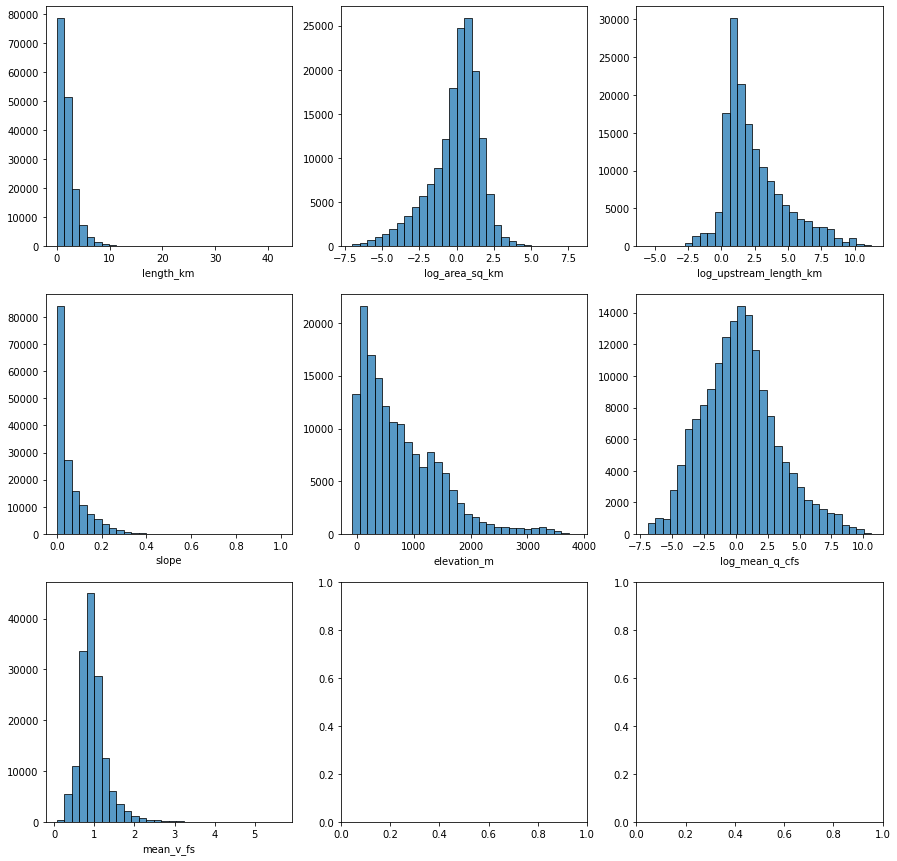

In [11]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15), sharey=False, sharex=False)
for ax, col in zip(axs.flatten(), num):
    sns.histplot(flowlines[col], ax=ax, bins=30)
    ax.set_ylabel('')

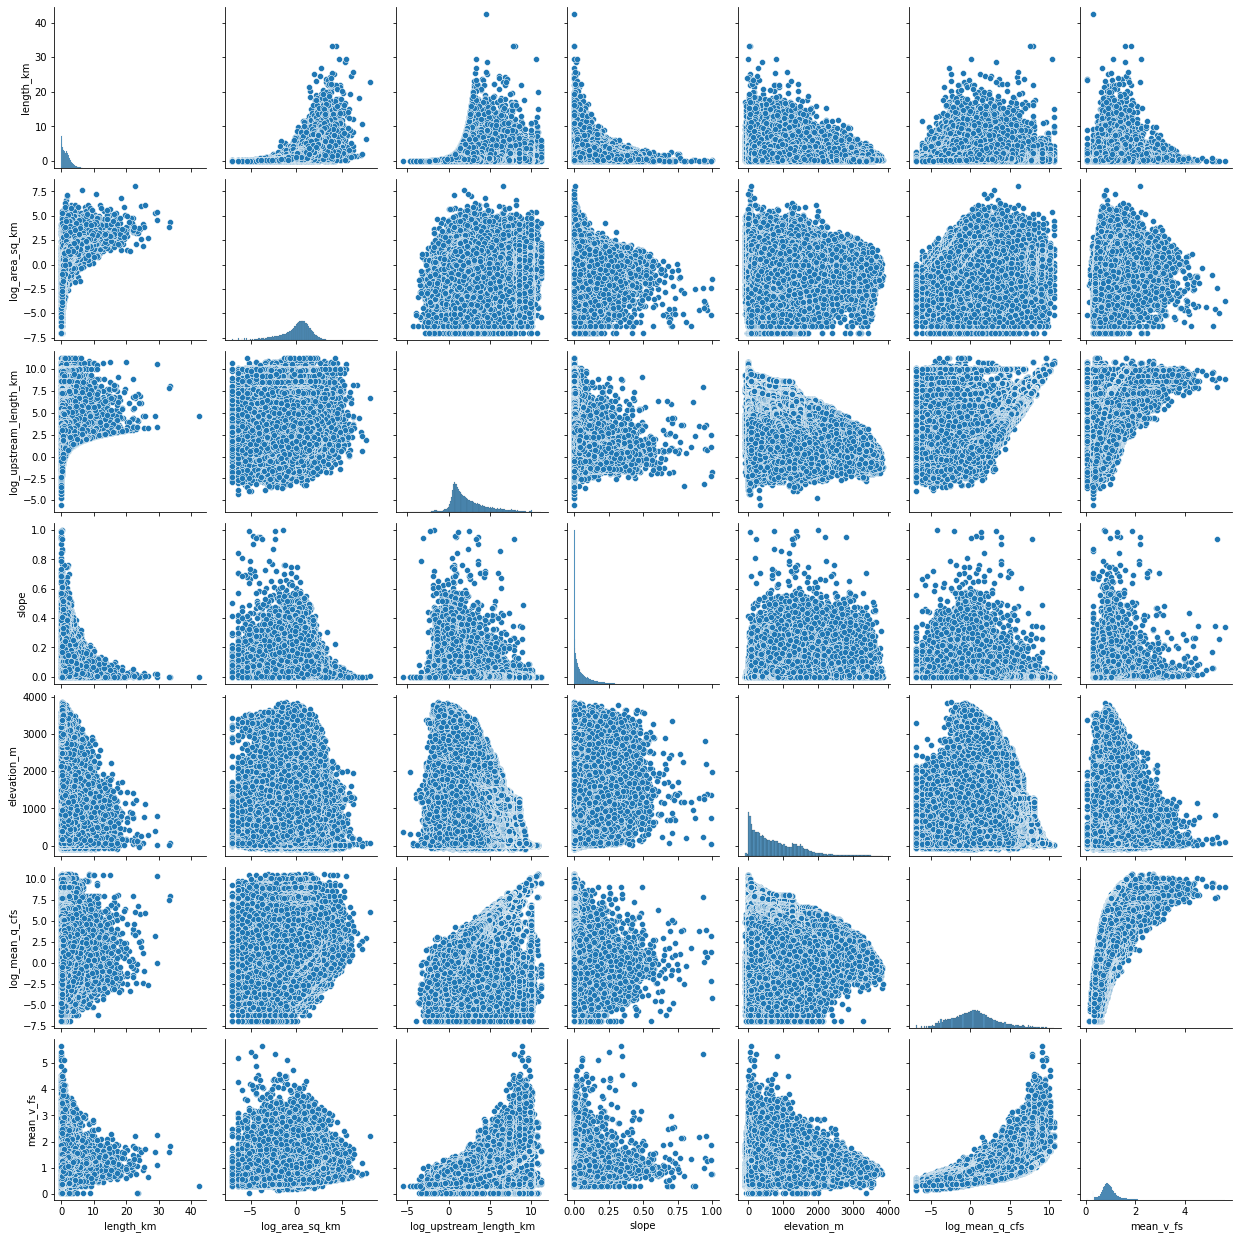

In [12]:
sns.pairplot(flowlines[num].drop_duplicates(), dropna=True)

Stream order, Region ~ Numeric Variables

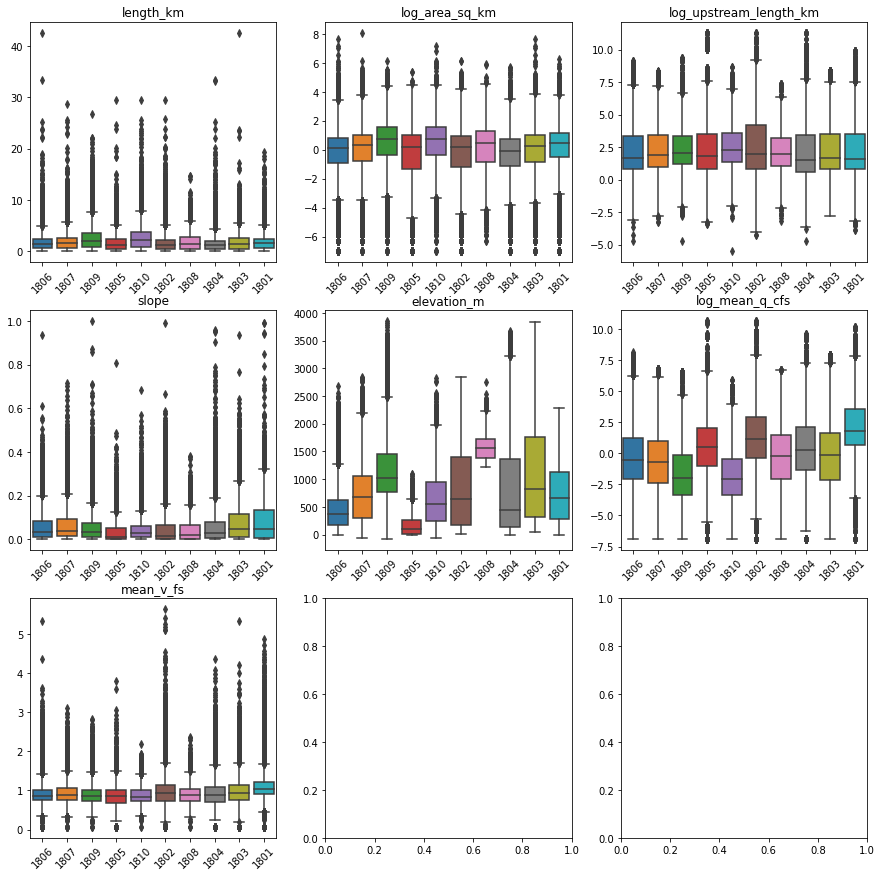

In [13]:
# visualize relationship between all variables and stream order
fig, axs = plt.subplots(3, 3, figsize=(15, 15), sharey=False)
for ax, col in zip(axs.flatten(), num):
    sns.boxplot(x='subregion', y=col, data=flowlines, ax=ax)
    ax.set_title(col)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

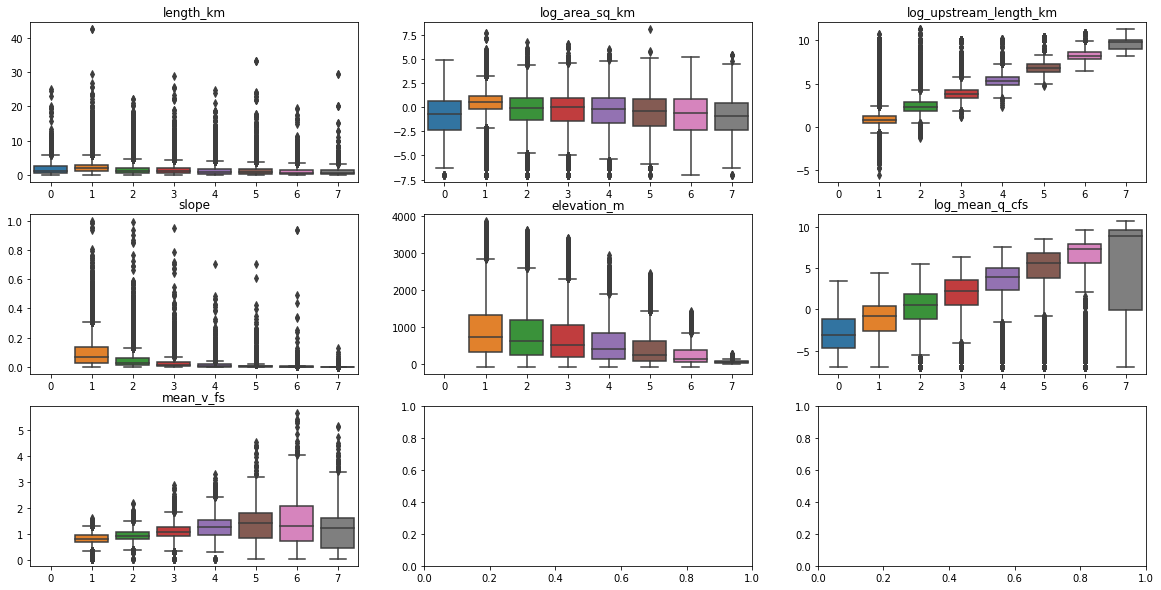

In [14]:
# visualize relationship between all variables and stream order
fig, axs = plt.subplots(3, 3, figsize=(20, 10))
for ax, col in zip(axs.flatten(), num):
    sns.boxplot(x='stream_order', y=col, data=flowlines, ax=ax)
    ax.set_title(col)
    ax.set_ylabel('')
    ax.set_xlabel('')